In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
size_of_frame = np.loadtxt(os.path.join('..', 'data', 'size_of_frame.txt'))
x_data = np.loadtxt(os.path.join('..', 'data', 'x_data.txt'))
y_data = np.loadtxt(os.path.join('..', 'data', 'y_data.txt'))
# audio = np.loadtxt(os.path.join('..', 'data', 'audio.wav'))

OSError: ..\data\size_of_frame.txt not found.

In [14]:
audio = np.random.rand(len(x_data)*1470, 1)*2-1


In [15]:
len(x_data)/30 == len(audio)/44100

True

In [16]:
import numpy as np
import cv2


class Grid:

    def __init__(self, size_of_frame, number_of_rows, number_of_cols, padding=0):
        """Constructor

        Args:
            size_of_frame (numpy.array): (horizontal, vertical)
            number_of_rows (int): 
            number_of_cols (int): 
            padding (int, optional): Padding arround the border. Defaults to 0.
        """
        self.size_of_frame = size_of_frame
        self.config(number_of_rows, number_of_cols, padding)

    def config(self,  number_of_rows, number_of_cols, padding=0):
        self.number_of_rows = number_of_rows
        self.number_of_cols = number_of_cols
        self.padding = padding
        self.padding_coords = np.array(
            [self.padding, self.padding]).astype(int)

        self.real_size = np.round(
            self.size_of_frame - (self.padding_coords * 2)).astype(int)

        self.grid_size = np.array(
            [self.real_size[0] / self.number_of_rows,
             self.real_size[1] / self.number_of_cols])

        self.hor_div = [int(self.real_size[1] / self.number_of_rows * i + padding)
                        for i in range(self.number_of_rows + 1)]
        self.ver_div = [int(self.real_size[0] / self.number_of_cols * i + padding)
                        for i in range(self.number_of_cols + 1)]

    def locate_point(self, point):
        point_grid_coords = np.array(point) - self.padding_coords
        return np.floor(point_grid_coords / self.grid_size).astype(int)

    def draw_grid(self, frame, color=(180, 180, 180), thickness=1):
        """ 
            TODO: se puede optimizar mucho: 
            crear una mascara que luego se reutilice para colorear todos 
            los frames siguientes
        """
        # DRAW HORIZONTAL DIVISIONS
        for div in self.hor_div:
            start_point = (self.padding, div)
            end_point = (self.size_of_frame[0]-self.padding, div)
            cv2.line(frame, start_point, end_point, color, thickness)

        # DRAW VERTICAL DIVISIONS
        for div in self.ver_div:
            start_point = (div, self.padding)
            end_point = (div, self.size_of_frame[1]-self.padding)
            cv2.line(frame, start_point, end_point, color, thickness)

        return frame

### Instrucciones
  - Primero hay que hacer "trim" a la data (video y audio)
  - Interpolar => interpolate_coords
  - y luego extraer los tramos

In [32]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from .package.services.path import interpolate_coords

x_data = interpolate_coords(x_data)
y_data = interpolate_coords(y_data)


Initial length of array: 862
Triming last block of Nan values: length = 1
Actual length of the Array: 861
Initial length of array: 862
Triming last block of Nan values: length = 1
Actual length of the Array: 861


In [66]:
data = np.transpose(np.array([x_data, y_data]))

grid = Grid(size_of_frame, 2, 3, 20)

start = 0
end = 0 
actual_grid = None

# Generate dictionary of the grid
dictionary = {}
for i in range(grid.number_of_cols):
    for j in range(grid.number_of_rows):
        dictionary[(j, i)] = []

for index in range(len(grid_list)):
    # Get x, y coords
    x, y = data[index]
    
    # Locate the coords in the grid system
    _grid = grid.locate_point((x, y))
    _grid = [int(i) for i in _grid] # np.array to python list

    if index == 0: actual_grid = _grid

    if actual_grid == _grid:
        end = index
    else:
        a = (_grid[0], _grid[1])
        dictionary[a].append((start, end))
        start = index
        end = index
        actual_grid = _grid

print(dictionary)

{(0, 0): [], (1, 0): [(484, 534)], (0, 1): [(150, 298), (676, 762)], (1, 1): [(299, 483), (535, 675)], (0, 2): [(0, 149), (763, 850)], (1, 2): []}


In [7]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from app.package.services import PyOctaveBand 

In [9]:
def getTime(B, e=0.1): 
    #   e = 1 / (B*T)^(1/2)
    return 1/(B*e**2)

def getSmallestBandwidth(low_freq, frac=3, fs=48000):
    freq, freq_d, freq_u = PyOctaveBand._genfreqs((low_freq, 10000), frac, fs)
    smallest_bandwidth = freq_u[0]-freq_d[0]
    return smallest_bandwidth

def getTimeOfRecording(lowest_freq, e = 0.1, frac = 3, fs = 48000):
    sb = getSmallestBandwidth(lowest_freq, frac, fs)
    return getTime(sb, e)

print(f'For 20Hz => {round(getTimeOfRecording(20), 1)}s')


For 20Hz => 21.7s


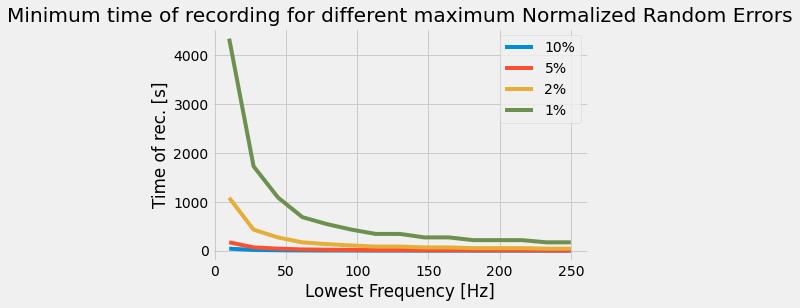

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

errors = [0.1, 0.05, 0.02]

low_freqs = np.linspace(10, 250, num=15)
smallest_bandwidths = [getSmallestBandwidth(f) for f in low_freqs]
times = [[getTime(b, e) for b in smallest_bandwidths] for e in errors]

fig, ax = plt.subplots()
for i in range(len(errors)):
    ax.plot(low_freqs, times[i], label=str(round(errors[i]*100))+'%')
    
ax.set_title('Minimum time of recording for different maximum Normalized Random Errors')
ax.set_xlabel(r'Lowest Frequency [Hz]')
ax.set_ylabel('Time of rec. [s]')
plt.legend()

In [8]:
import math

win_size = 2**13
overlap = 0.2
len_audio = 131540

expected_num_of_win = math.ceil(len_audio/win_size*(1+overlap))

i = 0
num_of_win = 0

while i+win_size < len_audio:
    num_of_win += 1
    i += math.floor(win_size-win_size*overlap)

print(num_of_win)
print(expected_num_of_win)

19
20
